### Building your network

In [1]:
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import DenseNet121, ResNet50, MobileNetV2

## DenseNet121

  - Size: 33MB
  - Top-1 Accuracy: 0.750
  - Top-5 Accuracy: 0.923
  - Parameters: 8,062,504
  - Depth: 121

In [2]:
densenet_model = DenseNet121(weights='imagenet',
                            include_top=False,
                            input_shape=(64,64,3))

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in densenet_model.layers])

# Getting output tensor of the last DenseNet201 layer that we want to include
x = layer_dict['relu'].output

# Stacking a new simple convolutional network on top of it    
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(33, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
custom_densenet_model = Model(densenet_model.input, x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_densenet_model.layers[:420]:
    layer.trainable = False

29089792/29084464 [==============================] - 0s 0us/step


In [3]:
custom_densenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [4]:
len(layer_dict)

427

## ResNet50

  - Size: 98MB
  - Top-1 Accuracy: 0.749
  - Top-5 Accuracy: 0.921
  - Parameters: 25,636,712
  - Depth: -

In [5]:
resnet_model = ResNet50(weights='imagenet',
                            include_top=False,
                            input_shape=(64,64,3))

layer_dict = dict([(layer.name, layer) for layer in resnet_model.layers])

x = layer_dict['conv5_block3_out'].output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(33, activation='softmax')(x)

custom_resnet_model = Model(resnet_model.input, x)

for layer in custom_resnet_model.layers[:171]:
    layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [6]:
custom_resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [7]:
len(layer_dict)

175

## MobileNetV2

  - Size: 14MB
  - Top-1 Accuracy: 0.713
  - Top-5 Accuracy: 0.901
  - Parameters: 3,538,984
  - Depth: 88

In [8]:
mobilenet_model = MobileNetV2(weights='imagenet',
                            include_top=False,
                            input_shape=(64,64,3))

layer_dict = dict([(layer.name, layer) for layer in mobilenet_model.layers])

x = layer_dict['out_relu'].output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(33, activation='softmax')(x)

custom_mobilenet_model = Model(mobilenet_model.input, x)

for layer in custom_mobilenet_model.layers[:150]:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
custom_mobilenet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [10]:
len(layer_dict)

155

## Compile

In [11]:
from tensorflow.keras import optimizers

custom_densenet_model.compile(loss='categorical_crossentropy',
                               optimizer= optimizers.Adam(lr=1e-3),
                               metrics=['acc'])

custom_resnet_model.compile(loss='categorical_crossentropy',
                               optimizer= optimizers.Adam(lr=1e-3),
                               metrics=['acc'])

custom_mobilenet_model.compile(loss='categorical_crossentropy',
                               optimizer= optimizers.Adam(lr=1e-3),
                               metrics=['acc'])

### Data preprocessing
Using ImageDataGenerator to read images from directories

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/drive/My Drive/Plant_leaf_split/dataset_split/train"
validation_dir = "/content/drive/My Drive/Plant_leaf_split/dataset_split/validation"

# Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir, # Target directory
    target_size=(64, 64), #Resizes all images to 64 × 64
    batch_size=32,
    class_mode='categorical')


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

Found 11765 images belonging to 33 classes.
Found 4786 images belonging to 33 classes.


### Fitting the model using a batch generator

In [18]:
history1 = custom_densenet_model.fit_generator(train_generator,
                                              steps_per_epoch=350,
                                              epochs=10,
                                              validation_data=validation_generator,
                                              validation_steps=150)

Epoch 1/10
350/350 [==============================] - 7200s 21s/step - loss: 1.0817 - acc: 0.6784 - val_loss: 0.8474 - val_acc: 0.7470
Epoch 2/10
350/350 [==============================] - 272s 778ms/step - loss: 0.4966 - acc: 0.8414 - val_loss: 0.6036 - val_acc: 0.8222
Epoch 3/10
350/350 [==============================] - 57s 162ms/step - loss: 0.3173 - acc: 0.8929 - val_loss: 0.5120 - val_acc: 0.8535
Epoch 4/10
350/350 [==============================] - 44s 126ms/step - loss: 0.2477 - acc: 0.9171 - val_loss: 0.5248 - val_acc: 0.8481
Epoch 5/10
350/350 [==============================] - 43s 122ms/step - loss: 0.1714 - acc: 0.9421 - val_loss: 0.6544 - val_acc: 0.8345
Epoch 6/10
350/350 [==============================] - 42s 121ms/step - loss: 0.1590 - acc: 0.9458 - val_loss: 0.5368 - val_acc: 0.8592
Epoch 7/10
350/350 [==============================] - 42s 121ms/step - loss: 0.1364 - acc: 0.9520 - val_loss: 0.5771 - val_acc: 0.8590
Epoch 8/10
350/350 [==============================] - 

In [19]:
history2 = custom_mobilenet_model.fit_generator(train_generator,
                                              steps_per_epoch=350,
                                              epochs=10,
                                              validation_data=validation_generator,
                                              validation_steps=150)

Epoch 1/10
350/350 [==============================] - 42s 121ms/step - loss: 1.5127 - acc: 0.5930 - val_loss: 13.8947 - val_acc: 0.0585
Epoch 2/10
350/350 [==============================] - 40s 115ms/step - loss: 0.9535 - acc: 0.7174 - val_loss: 8.9047 - val_acc: 0.0510
Epoch 3/10
350/350 [==============================] - 41s 118ms/step - loss: 0.7191 - acc: 0.7767 - val_loss: 7.3752 - val_acc: 0.1740
Epoch 4/10
350/350 [==============================] - 43s 122ms/step - loss: 0.6135 - acc: 0.8120 - val_loss: 10.4025 - val_acc: 0.1201
Epoch 5/10
350/350 [==============================] - 42s 119ms/step - loss: 0.5478 - acc: 0.8305 - val_loss: 9.7405 - val_acc: 0.1066
Epoch 6/10
350/350 [==============================] - 41s 116ms/step - loss: 0.4844 - acc: 0.8448 - val_loss: 7.2593 - val_acc: 0.1899
Epoch 7/10
350/350 [==============================] - 41s 116ms/step - loss: 0.4392 - acc: 0.8629 - val_loss: 4.7089 - val_acc: 0.2445
Epoch 8/10
350/350 [==============================] -

In [20]:
history3 = custom_mobilenet_model.fit_generator(train_generator,
                                              steps_per_epoch=350,
                                              epochs=10,
                                              validation_data=validation_generator,
                                              validation_steps=150)

Epoch 1/10
350/350 [==============================] - 40s 115ms/step - loss: 0.3197 - acc: 0.8962 - val_loss: 3.6727 - val_acc: 0.3101
Epoch 2/10
350/350 [==============================] - 40s 115ms/step - loss: 0.2948 - acc: 0.9037 - val_loss: 2.7983 - val_acc: 0.3765
Epoch 3/10
350/350 [==============================] - 41s 116ms/step - loss: 0.2651 - acc: 0.9104 - val_loss: 5.3262 - val_acc: 0.3552
Epoch 4/10
350/350 [==============================] - 40s 116ms/step - loss: 0.2715 - acc: 0.9120 - val_loss: 3.4916 - val_acc: 0.3523
Epoch 5/10
350/350 [==============================] - 40s 115ms/step - loss: 0.2872 - acc: 0.9110 - val_loss: 6.1676 - val_acc: 0.2756
Epoch 6/10
350/350 [==============================] - 43s 122ms/step - loss: 0.2540 - acc: 0.9198 - val_loss: 6.2502 - val_acc: 0.3132
Epoch 7/10
350/350 [==============================] - 41s 118ms/step - loss: 0.2349 - acc: 0.9272 - val_loss: 5.2249 - val_acc: 0.3930
Epoch 8/10
350/350 [==============================] - 4

### Saving the model

In [21]:
custom_densenet_model.save('/content/drive/My Drive/model_save/custom_densenet_model.h5')
custom_resnet_model.save('/content/drive/My Drive/model_save/custom_resnet_model.h5')
custom_mobilenet_model.save('/content/drive/My Drive/model_save/custom_mobilenet_model.h5')

### Displaying curves of loss and accuracy during training

## DenseNet121

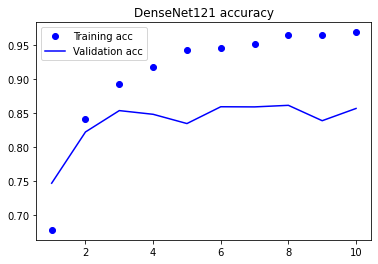

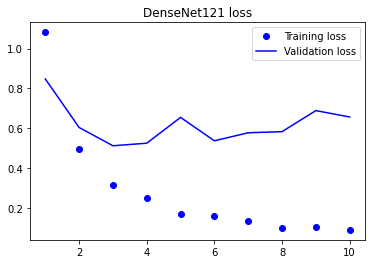

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('DenseNet121 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('DenseNet121 loss')
plt.legend()
plt.show()

#ResNet50

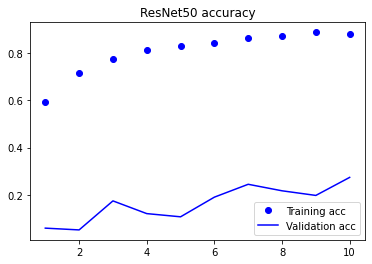

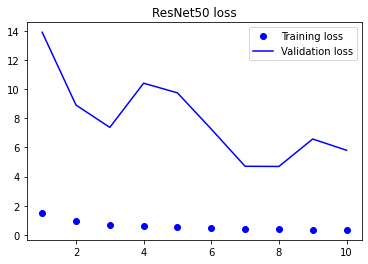

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('ResNet50 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('ResNet50 loss')
plt.legend()
plt.show()

#MobileNetV2

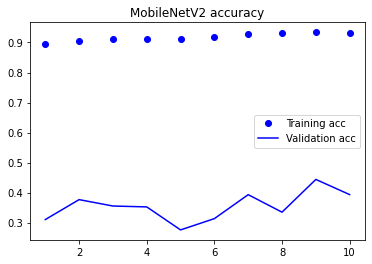

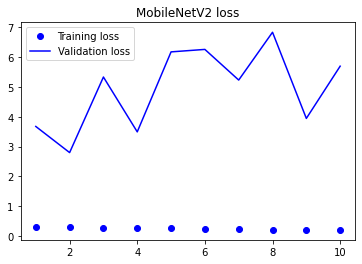

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('MobileNetV2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('MobileNetV2 loss')
plt.legend()
plt.show()

### Train the model on all samples (Training and Validation)

In [25]:
test_dir = "/content/drive/My Drive/Plant_leaf_split/dataset_split/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir, # Target directory
    target_size=(64, 64), #Resizes all images to 64 × 64
    batch_size=32,
    class_mode='categorical')


Found 5813 images belonging to 33 classes.


In [26]:
score1 = custom_densenet_model.evaluate_generator(test_generator, steps=150, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
score2 = custom_resnet_model.evaluate_generator(test_generator, steps=150, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
score3 = custom_mobilenet_model.evaluate_generator(test_generator, steps=150, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [27]:
print("DensNet121's acc: ",score1[1])
print("ResNet50's acc: ",score2[1])
print("MobileNetV2's acc: ",score3[1])

DensNet121's acc:  0.84395831823349
ResNet50's acc:  0.01770833320915699
MobileNetV2's acc:  0.4272916615009308
